<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_ref           5000 non-null   object 
 1   vendor_code        5000 non-null   object 
 2   product_type       5000 non-null   object 
 3   manufacturer       5000 non-null   object 
 4   cost_usd           3652 non-null   float64
 5   vendor_score       5000 non-null   float64
 6   feedback_count     5000 non-null   int64  
 7   image_qty          5000 non-null   int64  
 8   desc_chars         5000 non-null   int64  
 9   delivery_period    5000 non-null   int64  
 10  typo_count         5000 non-null   int64  
 11  site_age           5000 non-null   float64
 12  contact_valid      5000 non-null   bool   
 13  return_clarity     5000 non-null   bool   
 14  payment_options    5000 non-null   int64  
 15  post_timestamp     5000 non-null   object 
 16  vendor_nation      5000 

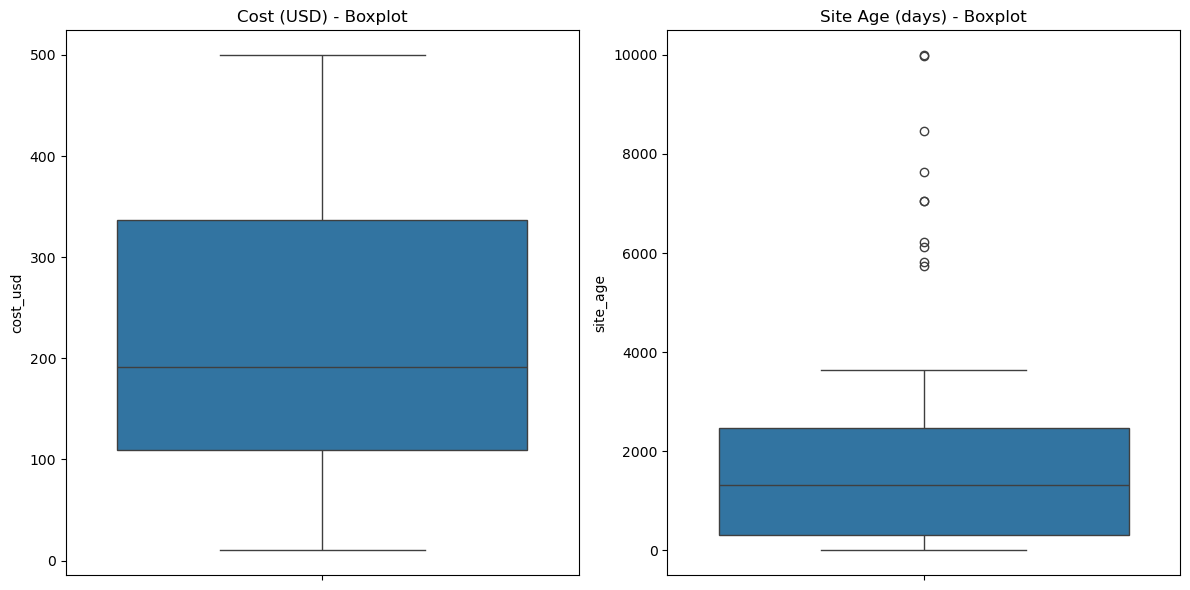

fraud_indicator
False    3530
True     1470
Name: count, dtype: int64


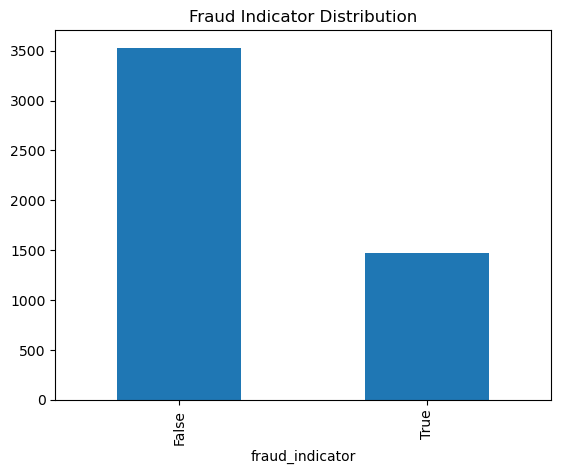

product_type
Luxury Goods        870
Pharmaceuticals     842
Automotive Parts    842
Electronics         841
Cosmetics           825
Name: count, dtype: int64
manufacturer
LuxuryBrand        200
HealthCare Plus    181
AutoParts Pro      180
CircuitMaster      176
ExclusiveItems     176
Name: count, dtype: int64
vendor_nation
FR    524
KR    520
US    519
CA    511
AU    504
Name: count, dtype: int64
vendor_code
seller_5587    5
seller_2286    5
seller_2688    4
seller_4536    4
seller_5747    4
Name: count, dtype: int64


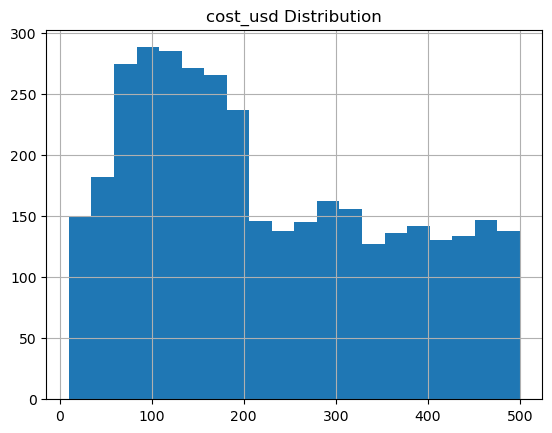

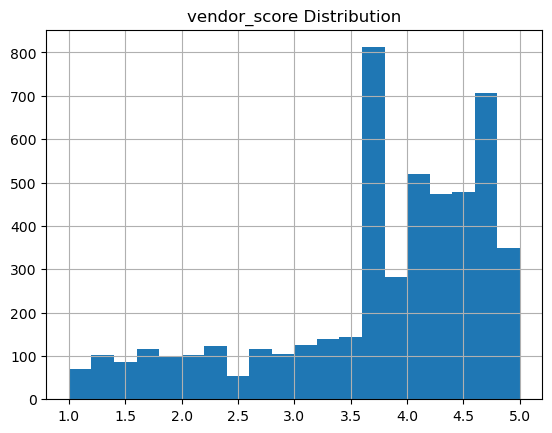

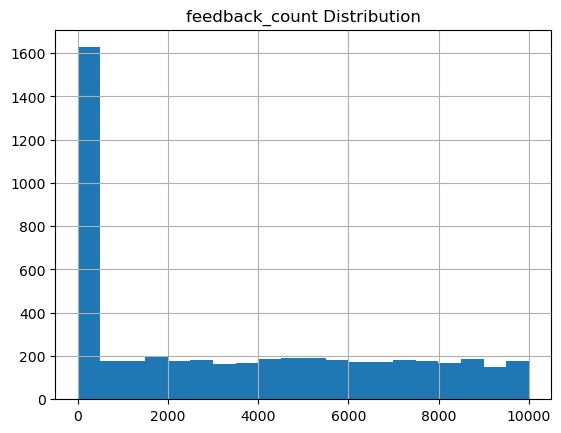

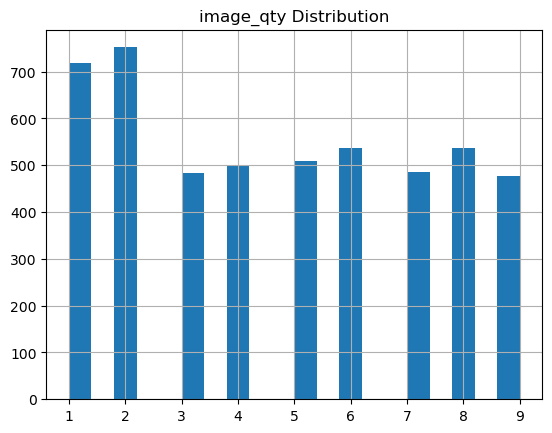

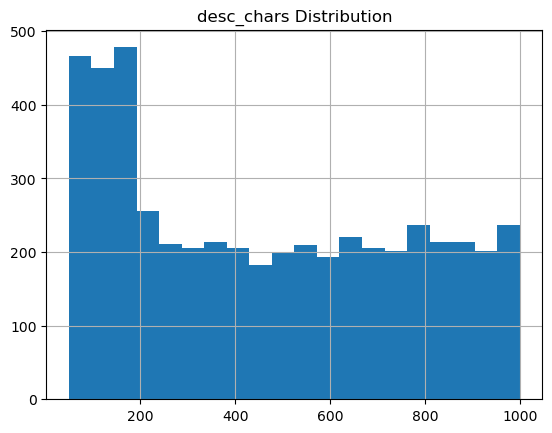

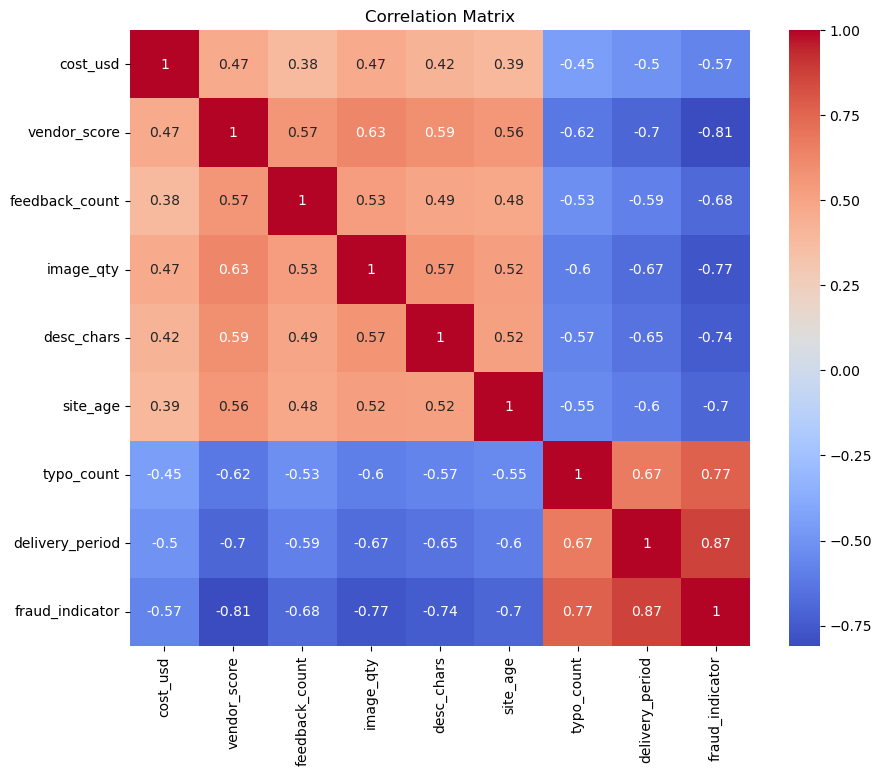

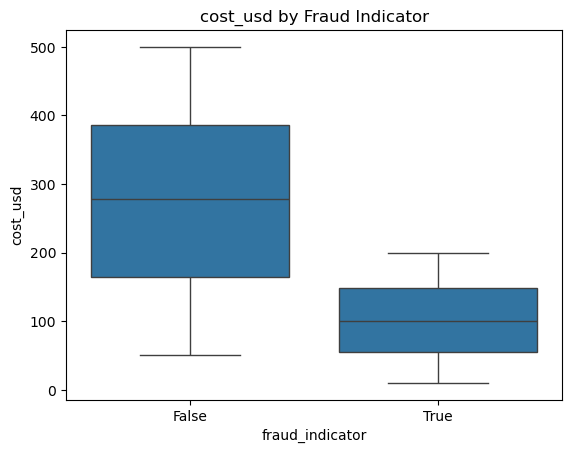

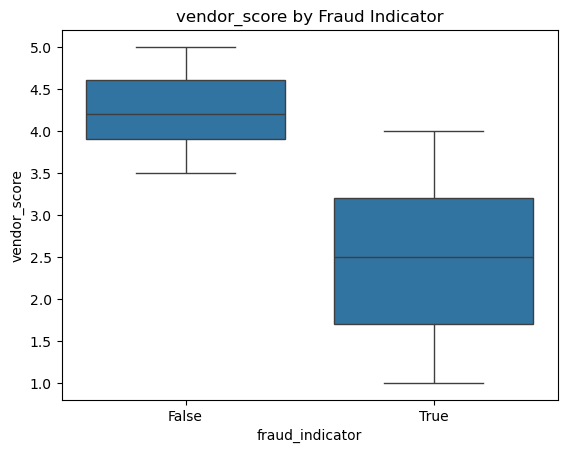

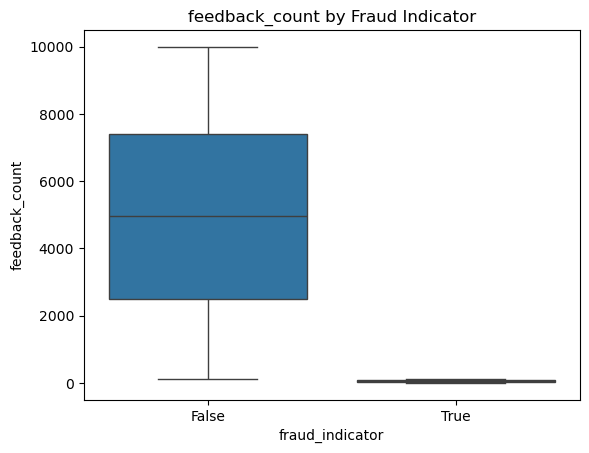

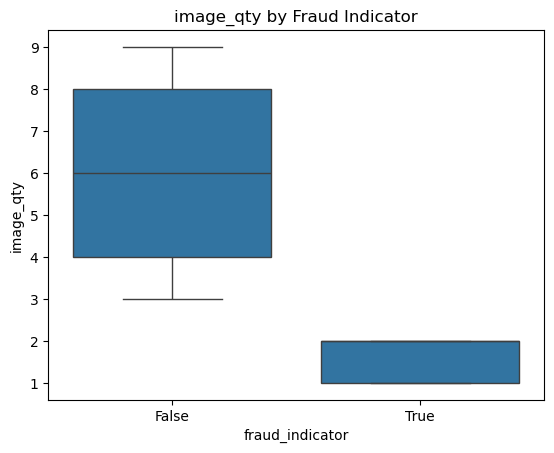

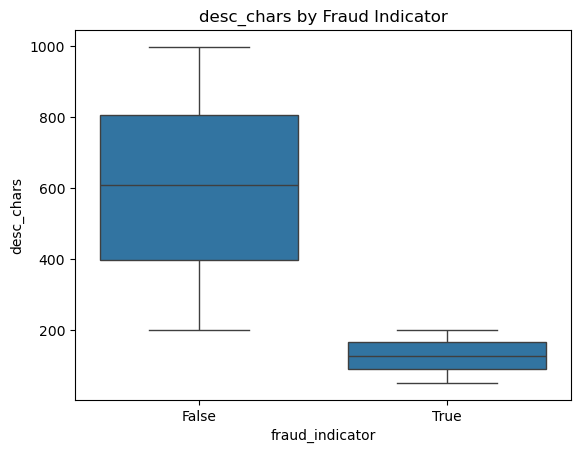

fraud_indicator   False  True 
product_type                  
Automotive Parts    580    262
Cosmetics           584    241
Electronics         573    268
Fashion             556    224
Luxury Goods        632    238
Pharmaceuticals     605    237
fraud_indicator   False  True 
manufacturer                  
AutoParts Pro       163     17
BeautyLux           153     14
BeautyLu×             0     82
BioMed Solutions    149     12
CarTech             152     19
CircuitMaster       158     18
CircuitMastr          0     96
ClassicWear         151     17
ClassicWear.          0     94
DigitalPr0            0    105
DigitalPro          134     13
ElectroMax          150     19
ElectroMx             0     76
EliteDesign         139     16
ExclusiveItems      159     17
FashionForward      142     15
FashionForward_       0     85
GlamourC0             0     97
GlamourCo           131     14
HealthCare Plus     157     24
LuxuryBrand         183     17
MediPharm           156     12
MotorMax

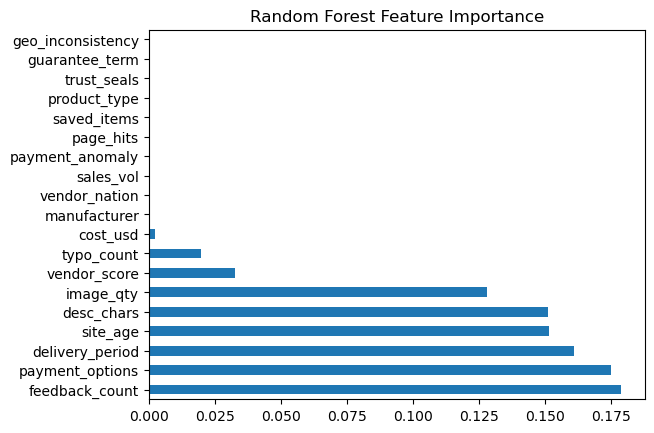

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

# 1. DATA LOADING AND PRELIMINARY ANALYSIS
df = pd.read_csv('counterfeit_products_renamed.csv')

# Data types, shape, and initial preview
print(df.info())
print(df.head())

# 2. MISSING VALUE ANALYSIS
print(df.isnull().sum())
missing_perc = df.isnull().mean() * 100
print(missing_perc)

# 3. OUTLIER & QUALITY CHECKS
# Numeric columns summary
print(df.describe())

# Check for obvious outliers in cost_usd and site_age
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.boxplot(df['cost_usd'])
plt.title('Cost (USD) - Boxplot')
plt.subplot(1, 2, 2)
sns.boxplot(df['site_age'])
plt.title('Site Age (days) - Boxplot')
plt.tight_layout()
plt.show()

# 4. DATA DISTRIBUTION ANALYSIS
# Target variable
fraud_counts = df['fraud_indicator'].value_counts()
print(fraud_counts)
fraud_counts.plot(kind='bar', title='Fraud Indicator Distribution')
plt.show()

# Example univariate for categorical & numerical features
cat_cols = ['product_type', 'manufacturer', 'vendor_nation', 'vendor_code']
for col in cat_cols:
    print(df[col].value_counts().head())

num_cols = ['cost_usd', 'vendor_score', 'feedback_count', 'image_qty', 'desc_chars']
for col in num_cols:
    df[col].hist(bins=20)
    plt.title(f"{col} Distribution")
    plt.show()

# 5. BIVARIATE & MULTIVARIATE ANALYSIS
# Correlation matrix for numeric features
corr = df[num_cols + ['site_age', 'typo_count', 'delivery_period', 'fraud_indicator']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Compare key numerics by fraud_indicator
for col in num_cols:
    sns.boxplot(x='fraud_indicator', y=col, data=df)
    plt.title(f"{col} by Fraud Indicator")
    plt.show()

# Example crosstab for categorical vs fraud
for col in cat_cols:
    print(pd.crosstab(df[col], df['fraud_indicator']))

# 6. DATA PREPROCESSING PIPELINE
# --- Copy and clean original dataframe
data = df.copy()

# Handle inconsistent date formats in post_timestamp, if needed
def fix_date(x):
    try:
        return pd.to_datetime(x, errors='coerce', dayfirst=True)
    except:
        return pd.NaT

data['post_timestamp'] = data['post_timestamp'].apply(fix_date)

# Fill numeric missing values with median, categorical with mode or 'Unknown'
num_feats = data.select_dtypes(include=[np.number]).columns
cat_feats = data.select_dtypes(include=['object', 'bool']).columns.drop('fraud_indicator')
for col in num_feats:
    data[col] = data[col].fillna(data[col].median())
for col in cat_feats:
    data[col] = data[col].fillna(data[col].mode())

# Encode categorical variables
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Encode boolean columns as int
bool_cols = data.select_dtypes(include='bool').columns
for col in bool_cols:
    data[col] = data[col].astype(int)

# 7. FEATURE SELECTION (Example: keep main features for initial model)
selected_features = [
    'cost_usd', 'vendor_score', 'feedback_count', 'image_qty', 'desc_chars',
    'delivery_period', 'site_age', 'typo_count', 'trust_seals', 'guarantee_term',
    'page_hits', 'sales_vol', 'saved_items', 'payment_options', 'payment_anomaly',
    'geo_inconsistency', 'product_type', 'manufacturer', 'vendor_nation'
]
selected_features = [f for f in selected_features if f in data.columns]

X = data[selected_features]
y = data['fraud_indicator'].astype(int)

# 8. DATA SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 9. BASELINE MODEL: LOGISTIC REGRESSION & RANDOM FOREST
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_clf = LogisticRegression(random_state=RANDOM_STATE)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Example: numeric preprocessing for Logistic Regression
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
log_scores = cross_val_score(log_clf, X_train_preprocessed, y_train, cv=cv, scoring='roc_auc')
rf_scores = cross_val_score(rf_clf, X_train_preprocessed, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression CV ROC-AUC: {np.mean(log_scores):.3f}")
print(f"Random Forest CV ROC-AUC: {np.mean(rf_scores):.3f}")

# Fit and evaluate
rf_clf.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_clf.predict(X_test_preprocessed)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_clf.predict_proba(X_test_preprocessed)[:,1]):.3f}")

log_clf.fit(X_train_preprocessed, y_train)
y_pred_log = log_clf.predict(X_test_preprocessed)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC: {roc_auc_score(y_test, log_clf.predict_proba(X_test_preprocessed)[:,1]):.3f}")

# 10. FEATURE IMPORTANCE VISUALIZATION (Optional)
feat_imp = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='barh', title="Random Forest Feature Importance")
plt.show()